In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


# === helpers ===
def get_z_for_confidence(confidence=0.95):
    try:
        from scipy.stats import norm
        return float(norm.ppf(1 - (1 - confidence) / 2))
    except Exception:
        return 1.96

def wilson_interval_counts(k, n, confidence=0.95):
    if n <= 0:
        return 0.0, 1.0
    z = get_z_for_confidence(confidence)
    p_hat = k / n
    denom = 1 + z**2 / n
    center = (p_hat + z**2 / (2 * n)) / denom
    margin = (z / denom) * math.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
    return max(0.0, center - margin), min(1.0, center + margin)

def normal_approx_se(p_hat, n):
    if n <= 0:
        return np.nan
    return math.sqrt(p_hat * (1 - p_hat) / n)

def dict_to_tidy_df_p(nested, basis="Z Basis", confidence=0.95, threshold=10):
    """
    Convert your nested dict (data_by_p.json) into tidy DataFrame for given basis.
    Each row corresponds to one physical error p_2 value.
    """
    p_phys = np.array(nested["p_2"], dtype=float)
    n_arr = np.array(nested["Num Samples"], dtype=int)
    n_cycles = np.array(nested["Num Cycles"], dtype=int)
    p_list = np.array(nested[basis]["Logical Error Rate"], dtype=float)
    se_list = np.array(nested[basis]["Standard Error"], dtype=float)

    rows = []
    for i, p2 in enumerate(p_phys):
        n = int(n_arr[i])
        p_hat = float(p_list[i])
        k = int(round(p_hat * n))
        se = float(se_list[i])
        cycles = int(n_cycles[i])
        z = get_z_for_confidence(confidence)
        ci_norm_low = max(0.0, p_hat - z * se)
        ci_norm_high = min(1.0, p_hat + z * se)
        ci_wilson_low, ci_wilson_high = wilson_interval_counts(k, n, confidence)
        use_normal = (n * p_hat >= threshold) and (n * (1 - p_hat) >= threshold)
        ci_lower = ci_norm_low if use_normal else ci_wilson_low
        ci_upper = ci_norm_high if use_normal else ci_wilson_high
        rows.append({
            "p_phys": p2,
            "n": n,
            "k": k,
            "cycles": cycles,
            "p_hat": p_hat,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "ci_width": ci_upper - ci_lower,
        })
    return pd.DataFrame(rows)

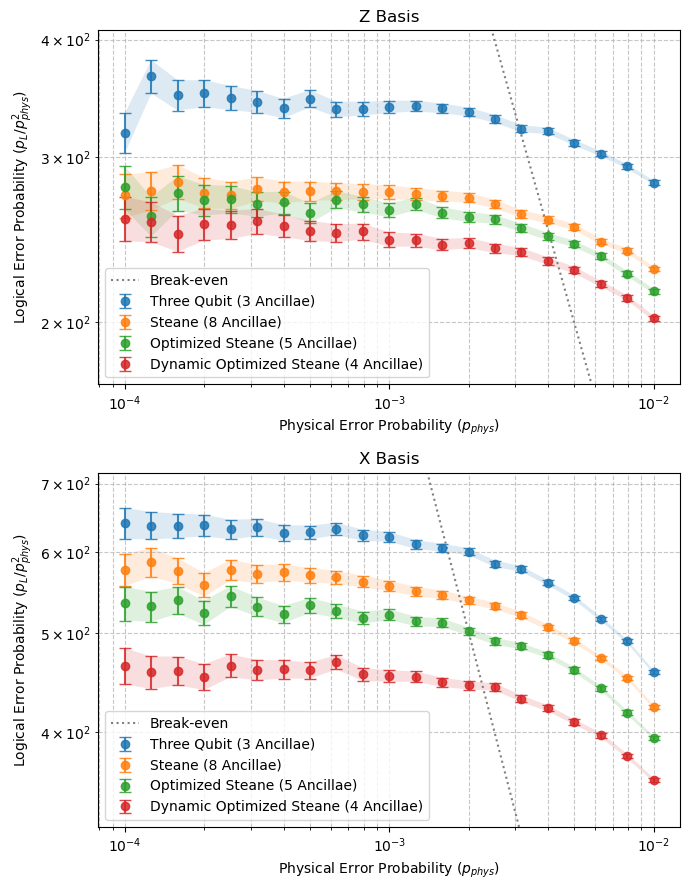

In [2]:
def plot_p_vs_p(df_dict, basis_label, ax, confidence=0.95, margin_bottom=0.15, margin_top=0.15):
    """Plot multiple datasets for given basis on one axis (log-log),
    with tight axis limits and shaded Wilson CIs."""
    all_x, all_y = [], []

    for label, df in df_dict.items():
        x = np.array(df["p_phys"])
        y = np.array(df["p_hat"]) / (x**2)  # p_logical / p_phys^2
        lower = np.array(df["ci_lower"]) / (x**2)
        upper = np.array(df["ci_upper"]) / (x**2)
        yerr = np.vstack([y - lower, upper - y])

        ax.errorbar(
            x, y,
            yerr=yerr,
            fmt="o",
            capsize=4,
            label=label,
            alpha=0.85
        )
        ax.fill_between(x, lower, upper, alpha=0.15)

        all_x.extend(x)
        all_y.extend(y)

    ax.plot(x, 1 / x, linestyle=":", color="gray", label="Break-even")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Physical Error Probability ($p_{phys}$)")
    ax.set_ylabel("Logical Error Probability ($p_L / p_{phys}^2$)")
    ax.set_title(basis_label)
    ax.grid(True, which="both", ls="--", alpha=0.7)
    ax.legend()

    # --- Tight axis limits ---
    y_min, y_max = np.min(all_y), np.max(all_y)

    # add a margin in log-space
    ax.set_ylim(y_min * (1 - margin_bottom), y_max * (1 + margin_top))


# === load JSON files for p-based data ===
with open("data/flagged_three_qubit_data_by_p.json", "r") as infile:
    three_qubit = json.load(infile)
with open("data/steane_data_by_p.json", "r") as infile:
    steane = json.load(infile)
with open("data/floquetified_steane_data_by_p.json", "r") as infile:
    floq_steane = json.load(infile)
with open("data/dynamic_floq_steane_data_by_p.json", "r") as infile:
    dynamic_floq_steane = json.load(infile)

# === prepare tidy dataframes ===
confidence = 0.95
datasets = {
    "Three Qubit (3 Ancillae)": three_qubit,
    "Steane (8 Ancillae)": steane,
    "Optimized Steane (5 Ancillae)": floq_steane,
    "Dynamic Optimized Steane (4 Ancillae)": dynamic_floq_steane
}

dfs_z = {label: dict_to_tidy_df_p(d, "Z Basis", confidence) for label, d in datasets.items()}
dfs_x = {label: dict_to_tidy_df_p(d, "X Basis", confidence) for label, d in datasets.items()}

# === plotting ===
fig, axes = plt.subplots(2, 1, figsize=(7, 9), sharex=False)
plot_p_vs_p(dfs_z, "Z Basis", axes[0], confidence, margin_top=0.12)
plot_p_vs_p(dfs_x, "X Basis", axes[1], confidence, margin_top=0.12, margin_bottom=0.1)

fig.tight_layout()
plt.savefig("logical_error_per_physical_error_wilson.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

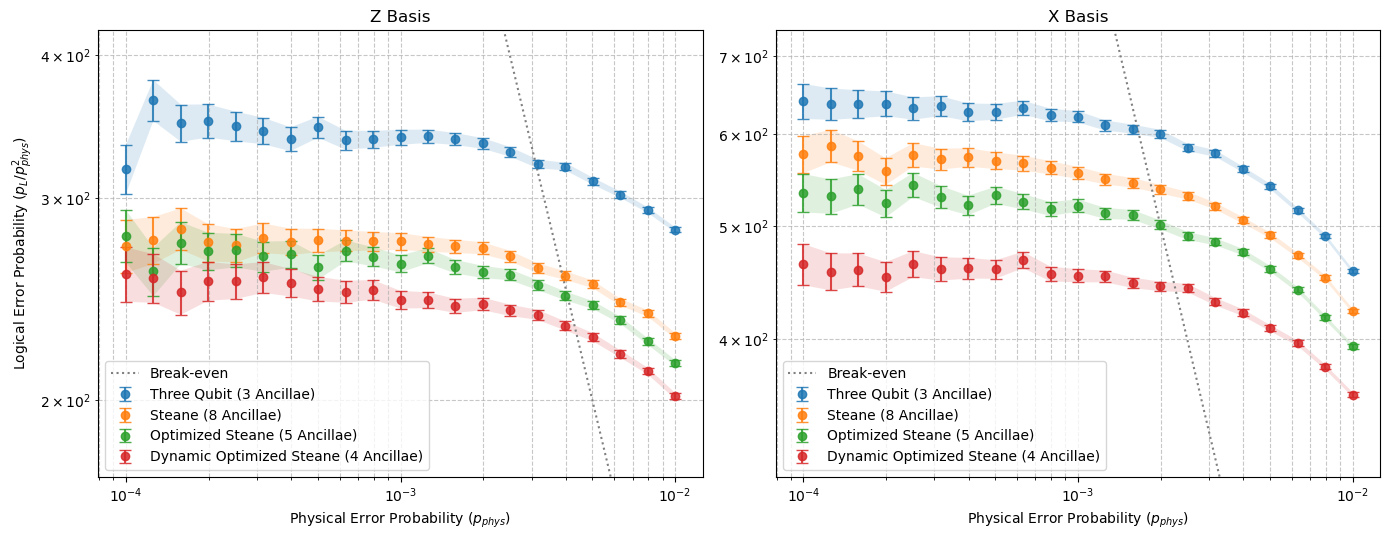

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5), sharex=False)
plot_p_vs_p(dfs_z, "Z Basis", axes[0], confidence)
plot_p_vs_p(dfs_x, "X Basis", axes[1], confidence)
axes[1].set_ylabel("")

fig.tight_layout()
plt.savefig("logical_error_per_physical_error_wilson_vertical.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
def calculate_decrease(ls1, ls2):
    ln = min(len(ls1), len(ls2))
    return 1 - (np.array(ls1[:ln]) / ls2[:ln])


def calculate_avg_decrease(ls1, ls2):
    ln = min(len(ls1), len(ls2))
    return np.mean(1 - (np.array(ls1[:ln]) / ls2[:ln]))


z_from_steane = calculate_avg_decrease(dynamic_floq_steane["Z Basis"]["Logical Error Rate"], steane["Z Basis"]["Logical Error Rate"])
z_from_floq = calculate_avg_decrease(dynamic_floq_steane["Z Basis"]["Logical Error Rate"], floq_steane["Z Basis"]["Logical Error Rate"])
z_from_three = calculate_avg_decrease(dynamic_floq_steane["Z Basis"]["Logical Error Rate"], three_qubit["Z Basis"]["Logical Error Rate"])

x_from_steane = calculate_avg_decrease(dynamic_floq_steane["X Basis"]["Logical Error Rate"], steane["X Basis"]["Logical Error Rate"])
x_from_floq = calculate_avg_decrease(dynamic_floq_steane["X Basis"]["Logical Error Rate"], floq_steane["X Basis"]["Logical Error Rate"])
x_from_three = calculate_avg_decrease(dynamic_floq_steane["X Basis"]["Logical Error Rate"], three_qubit["X Basis"]["Logical Error Rate"])

dynamic_floq_steane_avg = (np.array(dynamic_floq_steane["X Basis"]["Logical Error Rate"]) + dynamic_floq_steane["Z Basis"]["Logical Error Rate"]) / 2
floq_steane_avg = (np.array(floq_steane["X Basis"]["Logical Error Rate"]) + floq_steane["Z Basis"]["Logical Error Rate"]) / 2
steane_avg = (np.array(steane["X Basis"]["Logical Error Rate"]) + steane["Z Basis"]["Logical Error Rate"]) / 2
three_qubit_avg = (np.array(three_qubit["X Basis"]["Logical Error Rate"]) + three_qubit["Z Basis"]["Logical Error Rate"]) / 2

from_steane = calculate_avg_decrease(dynamic_floq_steane_avg, steane_avg)
from_floq = calculate_avg_decrease(dynamic_floq_steane_avg, floq_steane_avg)
from_three = calculate_avg_decrease(dynamic_floq_steane_avg, three_qubit_avg)


print("Decrease of Logical Error Probability / Physical Error Probability")
print()
print("Z Basis")
print(f"Dynamic optimized Steane from Steane avg decrease: {z_from_steane:.1%}")
print(f"Dynamic optimized Steane from optimized Steane avg decrease: {z_from_floq:.1%}")
print(f"Dynamic optimized Steane from three-qubit avg decrease: {z_from_three:.1%}")
print()

print("X Basis")
print(f"Dynamic optimized Steane from Steane avg decrease: {x_from_steane:.1%}")
print(f"Dynamic optimized Steane from optimized Steane avg decrease: {x_from_floq:.1%}")
print(f"Dynamic optimized Steane from three-qubit avg decrease: {x_from_three:.1%}")
print()

print("Average over Z and X bases")
print(f"Dynamic optimized Steane from Steane avg decrease: {from_steane:.1%}")
print(f"Dynamic optimized Steane from optimized Steane avg decrease: {from_floq:.1%}")
print(f"Dynamic optimized Steane from three-qubit avg decrease: {from_three:.1%}")

Decrease of Logical Error Probability / Physical Error Probability

Z Basis
Dynamic optimized Steane from Steane avg decrease: 9.4%
Dynamic optimized Steane from optimized Steane avg decrease: 6.2%
Dynamic optimized Steane from three-qubit avg decrease: 26.9%

X Basis
Dynamic optimized Steane from Steane avg decrease: 18.1%
Dynamic optimized Steane from optimized Steane avg decrease: 12.0%
Dynamic optimized Steane from three-qubit avg decrease: 25.9%

Average over Z and X bases
Dynamic optimized Steane from Steane avg decrease: 15.2%
Dynamic optimized Steane from optimized Steane avg decrease: 10.0%
Dynamic optimized Steane from three-qubit avg decrease: 26.3%


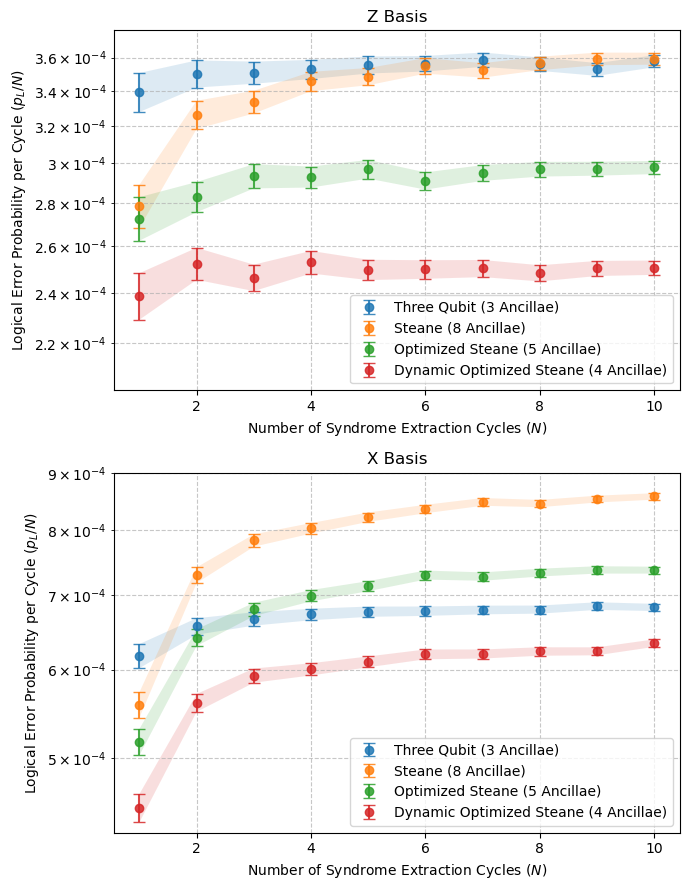

In [5]:
with open("data/flagged_three_qubit_data_by_cycle.json", "r") as infile:
    three_qubit = json.load(infile)
with open("data/steane_data_by_cycle.json", "r") as infile:
    steane = json.load(infile)
with open("data/floquetified_steane_data_by_cycle.json", "r") as infile:
    floq_steane = json.load(infile)
with open("data/dynamic_floq_steane_data_by_cycle.json", "r") as infile:
    dynamic_floq_steane = json.load(infile)


# === prepare tidy dataframes ===
confidence = 0.95
datasets = {
    "Three Qubit (3 Ancillae)": three_qubit,
    "Steane (8 Ancillae)": steane,
    "Optimized Steane (5 Ancillae)": floq_steane,
    "Dynamic Optimized Steane (4 Ancillae)": dynamic_floq_steane
}

dfs_z = {label: dict_to_tidy_df_p(d, "Z Basis", confidence) for label, d in datasets.items()}
dfs_x = {label: dict_to_tidy_df_p(d, "X Basis", confidence) for label, d in datasets.items()}


def plot_p_vs_cycles(df_dict, basis_label, ax, confidence=0.95, margin_bottom=0.15, margin_top=0.15):
    """Plot multiple datasets for given basis on one axis (log-log),
    with tight axis limits and shaded Wilson CIs."""
    all_x, all_y = [], []

    for label, df in df_dict.items():
        x = np.array(df["cycles"][1:])
        y = np.array(df["p_hat"][1:]) / (x)  # p_logical / N
        lower = np.array(df["ci_lower"][1:]) / x
        upper = np.array(df["ci_upper"][1:]) / x
        yerr = np.vstack([y - lower, upper - y])

        ax.errorbar(
            x, y,
            yerr=yerr,
            fmt="o",
            capsize=4,
            label=label,
            alpha=0.85
        )
        ax.fill_between(x, lower, upper, alpha=0.15)
        # ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        all_x.extend(x)
        all_y.extend(y)

    ax.set_yscale("log")
    ax.set_xlabel("Number of Syndrome Extraction Cycles ($N$)")
    ax.set_ylabel("Logical Error Probability per Cycle ($p_L / N$)")
    ax.set_title(basis_label)
    ax.grid(True, which="both", ls="--", alpha=0.7)
    ax.legend()

    # --- Tight axis limits ---
    y_min, y_max = np.min(all_y), np.max(all_y)

    # add a margin in log-space
    ax.set_ylim(y_min * (1 - margin_bottom), y_max * (1 + margin_top))

# === plotting ===
fig, axes = plt.subplots(2, 1, figsize=(7, 9), sharex=False)
plot_p_vs_cycles(dfs_z, "Z Basis", axes[0], confidence, margin_top=0.05, margin_bottom=0.15)
plot_p_vs_cycles(dfs_x, "X Basis", axes[1], confidence, margin_top=0.05, margin_bottom=0.05)
axes[0].legend(loc="lower right")

fig.tight_layout()
plt.savefig("logical_error_per_cycles_wilson.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
def calculate_decrease(ls1, ls2):
    ln = min(len(ls1), len(ls2))
    return 1 - (np.array(ls1[:ln]) / ls2[:ln])


def calculate_avg_decrease(ls1, ls2):
    ln = min(len(ls1), len(ls2))
    return np.mean(1 - (np.array(ls1[:ln]) / ls2[:ln]))


z_from_steane = calculate_avg_decrease(dynamic_floq_steane["Z Basis"]["Logical Error Rate"][1:], steane["Z Basis"]["Logical Error Rate"][1:])
z_from_floq = calculate_avg_decrease(dynamic_floq_steane["Z Basis"]["Logical Error Rate"][1:], floq_steane["Z Basis"]["Logical Error Rate"][1:])
z_from_three = calculate_avg_decrease(dynamic_floq_steane["Z Basis"]["Logical Error Rate"][1:], three_qubit["Z Basis"]["Logical Error Rate"][1:])

x_from_steane = calculate_avg_decrease(dynamic_floq_steane["X Basis"]["Logical Error Rate"][1:], steane["X Basis"]["Logical Error Rate"][1:])
x_from_floq = calculate_avg_decrease(dynamic_floq_steane["X Basis"]["Logical Error Rate"][1:], floq_steane["X Basis"]["Logical Error Rate"][1:])
x_from_three = calculate_avg_decrease(dynamic_floq_steane["X Basis"]["Logical Error Rate"][1:], three_qubit["X Basis"]["Logical Error Rate"][1:])

dynamic_floq_steane_avg = (np.array(dynamic_floq_steane["X Basis"]["Logical Error Rate"][1:]) + dynamic_floq_steane["Z Basis"]["Logical Error Rate"][1:]) / 2
floq_steane_avg = (np.array(floq_steane["X Basis"]["Logical Error Rate"][1:]) + floq_steane["Z Basis"]["Logical Error Rate"][1:]) / 2
steane_avg = (np.array(steane["X Basis"]["Logical Error Rate"][1:]) + steane["Z Basis"]["Logical Error Rate"][1:]) / 2
three_qubit_avg = (np.array(three_qubit["X Basis"]["Logical Error Rate"][1:]) + three_qubit["Z Basis"]["Logical Error Rate"][1:]) / 2

from_steane = calculate_avg_decrease(dynamic_floq_steane_avg, steane_avg)
from_floq = calculate_avg_decrease(dynamic_floq_steane_avg, floq_steane_avg)
from_three = calculate_avg_decrease(dynamic_floq_steane_avg, three_qubit_avg)


print("Average Decrease of Logical Error Probability (/ QEC cycles) per Basis")
print()
print("Z Basis")
print(f"Dynamic optimized Steane from Steane avg decrease: {z_from_steane:.1%}")
print(f"Dynamic optimized Steane from optimized Steane avg decrease: {z_from_floq:.1%}")
print(f"Dynamic optimized Steane from three-qubit avg decrease: {z_from_three:.1%}")
print()

print("X Basis")
print(f"Dynamic optimized Steane from Steane avg decrease: {x_from_steane:.1%}")
print(f"Dynamic optimized Steane from optimized Steane avg decrease: {x_from_floq:.1%}")
print(f"Dynamic optimized Steane from three-qubit avg decrease: {x_from_three:.1%}")
print()

print("Average over Z and X bases")
print(f"Dynamic optimized Steane from Steane avg decrease: {from_steane:.1%}")
print(f"Dynamic optimized Steane from optimized Steane avg decrease: {from_floq:.1%}")
print(f"Dynamic optimized Steane from three-qubit avg decrease: {from_three:.1%}")

Average Decrease of Logical Error Probability (/ QEC cycles) per Basis

Z Basis
Dynamic optimized Steane from Steane avg decrease: 26.8%
Dynamic optimized Steane from optimized Steane avg decrease: 14.6%
Dynamic optimized Steane from three-qubit avg decrease: 29.5%

X Basis
Dynamic optimized Steane from Steane avg decrease: 25.0%
Dynamic optimized Steane from optimized Steane avg decrease: 14.1%
Dynamic optimized Steane from three-qubit avg decrease: 11.5%

Average over Z and X bases
Dynamic optimized Steane from Steane avg decrease: 25.5%
Dynamic optimized Steane from optimized Steane avg decrease: 14.3%
Dynamic optimized Steane from three-qubit avg decrease: 17.7%
